# Elevrad, toporad and stoporad

Ensure that the conversion of the 3 functions to Python match with the IPW versions

In [2]:
import os
import glob
import netCDF4 as nc
import pandas as pd
import numpy as np
import subprocess as sp
from spatialnc import ipw
from spatialnc.topo import get_topo_stats
from topocalc.shade import shade
from topocalc.horizon import horizon
from topocalc import gradient
import matplotlib.pyplot as plt
import seaborn as sns

from smrf.data import loadTopo
from smrf.envphys.sunang import sunang
from smrf.envphys.albedo import albedo
from smrf.envphys.solar import toporad, irradiance
from smrf.utils import utils

# %matplotlib widget

sns.set_context('poster')

In [3]:
# Topo, create an IPW image from topo, sky view factor and terrain config factor

# Load the netcdf dem and get all the geo coords for IPW
topo_path = '../tests/Lakes/topo/topo.nc'

topo_config = {
    'filename': topo_path,
    'northern_hemisphere': True,
    'gradient_method': 'gradient_d8',
    'sky_view_factor_angles': 72
}
topo = loadTopo.Topo(topo_config, tempDir='.')
dem = topo.dem

ts = get_topo_stats(topo_path)

csys = 'UTM'
nbits = 16

# Create the IPW image for dem
ipw_image = ipw.IPW()
ipw_image.new_band(dem)
ipw_image.add_geo_hdr(
    coordinates=[ts['u'], ts['v']],
    d=[ts['dv'], ts['du']],
    units=ts['units'],
    csys=csys
)
ipw_image.write('lakes_dem.ipw', nbits=nbits)

# Create the IPW image for sky view factor
ipw_image = ipw.IPW()
ipw_image.new_band(topo.sky_view_factor)
ipw_image.add_geo_hdr(
    coordinates=[ts['u'], ts['v']],
    d=[ts['dv'], ts['du']],
    units=ts['units'],
    csys=csys
)
ipw_image.write('svf.ipw', nbits=nbits)

# Create the IPW image for terrain configuration factor
ipw_image = ipw.IPW()
ipw_image.new_band(topo.terrain_config_factor)
ipw_image.add_geo_hdr(
    coordinates=[ts['u'], ts['v']],
    d=[ts['dv'], ts['du']],
    units=ts['units'],
    csys=csys
)
ipw_image.write('tcf.ipw', nbits=nbits)



In [10]:
# Parameters for elevrad, toporad and stoporad

date_time = pd.to_datetime('2/15/1990 20:30')
date_time = date_time.tz_localize('UTC')

tau_elevation = 100
tau = 0.2
omega = 0.85
scattering_factor = 0.3
surface_albedo = 0.5
grain_size = 100.0
max_grain = 2000.0
dirt = 2.0
solar_irradiance = irradiance.direct_solar_irradiance(
    date_time, w=[0.28, 2.8])

cosz, azimuth, rad_vec = sunang(
    date_time,
    topo.basin_lat,
    topo.basin_long)

illum_ang = shade(
    topo.sin_slope,
    topo.aspect,
    azimuth,
    cosz)

alb = albedo(10 * np.ones_like(dem), illum_ang, 100, 700)

# Create the IPW image for illumination angle
ipw_image = ipw.IPW()
ipw_image.new_band(illum_ang)
ipw_image.add_geo_hdr(
    coordinates=[ts['u'], ts['v']],
    d=[ts['dv'], ts['du']],
    units=ts['units'],
    csys=csys
)

ipw_image.write('illum_angle.ipw', nbits=nbits)

# Create the IPW image for albedo
ipw_image = ipw.IPW()
ipw_image.new_band(alb[0])
ipw_image.add_geo_hdr(
    coordinates=[ts['u'], ts['v']],
    d=[ts['dv'], ts['du']],
    units=ts['units'],
    csys=csys
)

ipw_image.write('albedo.ipw', nbits=nbits)


elevrad -z 100 -t 0.2 -w 0.85 -g 0.3 -r 0.5 -s 1321.0014737319768 -u 0.638023 -n 16 lakes_dem.ipw > elevrad.ipw


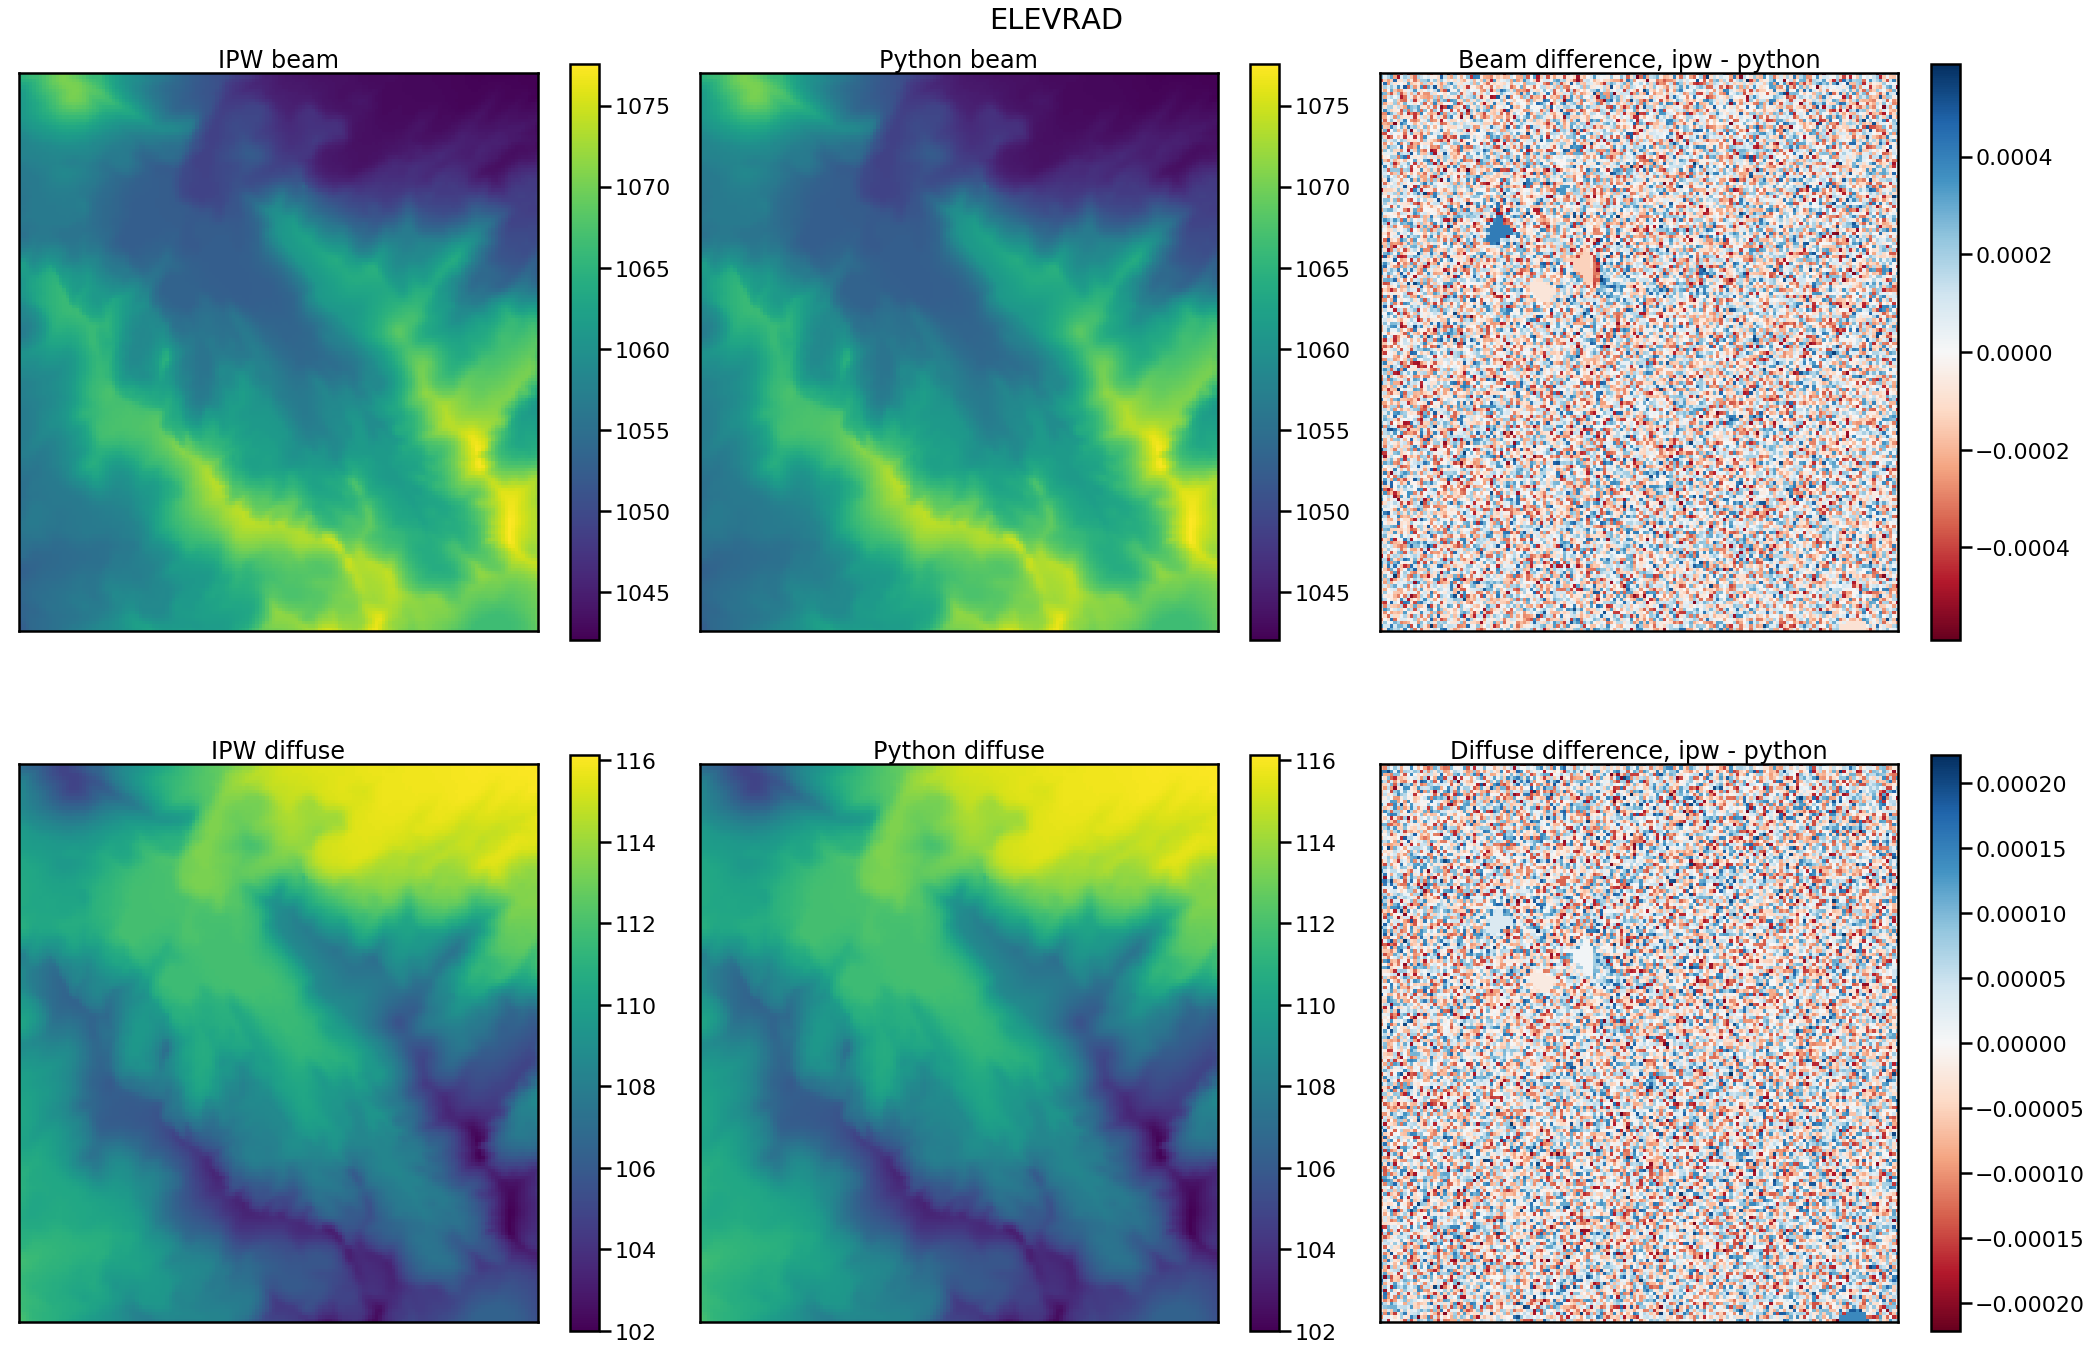

In [11]:
# Elevrad
# The only difference is bit resolution noise

# Call IPW elevrad
cmd = f"elevrad -z {tau_elevation} -t {tau} -w {omega} -g {scattering_factor} -r {surface_albedo} -s {solar_irradiance} -u {cosz} -n 16 lakes_dem.ipw > elevrad.ipw"

print(cmd)
visp = sp.Popen(cmd, shell=True)
visp.wait()

elevrad_ipw = ipw.IPW('elevrad.ipw')

# Python elevrad
elevrad_py = toporad.Elevrad(
    dem,
    solar_irradiance,
    cosz)

# Plot
fig, ax = plt.subplots(2, 3, figsize = (30, 20))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
fig.suptitle('ELEVRAD')

# IPW originals
im0 = ax[0, 0].imshow(elevrad_ipw.bands[0].data)
ax[0, 0].set_title('IPW beam')
fig.colorbar(im0, ax=ax[0, 0])

im0 = ax[1, 0].imshow(elevrad_ipw.bands[1].data)
ax[1, 0].set_title('IPW diffuse')
fig.colorbar(im0, ax=ax[1, 0])

# Python elevrad
im0 = ax[0, 1].imshow(elevrad_py.beam)
ax[0, 1].set_title('Python beam')
fig.colorbar(im0, ax=ax[0, 1])

im0 = ax[1, 1].imshow(elevrad_py.diffuse)
ax[1, 1].set_title('Python diffuse')
fig.colorbar(im0, ax=ax[1, 1])

# difference
d = elevrad_ipw.bands[0].data - elevrad_py.beam
var_lim = max([abs(d.min()), abs(d.max())])
im2 = ax[0, 2].imshow(d, cmap='RdBu', vmin=-var_lim, vmax=var_lim)
ax[0, 2].set_title('Beam difference, ipw - python')
fig.colorbar(im2, ax=ax[0, 2])

d = elevrad_ipw.bands[1].data - elevrad_py.diffuse
var_lim = max([abs(d.min()), abs(d.max())])
im2 = ax[1, 2].imshow(d, cmap='RdBu', vmin=-var_lim, vmax=var_lim)
ax[1, 2].set_title('Diffuse difference, ipw - python')
fig.colorbar(im2, ax=ax[1, 2])

# remove the x and y ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

mux elevrad.ipw illum_angle.ipw svf.ipw tcf.ipw albedo.ipw | toporad -r 0.5 -d > toporad.ipw


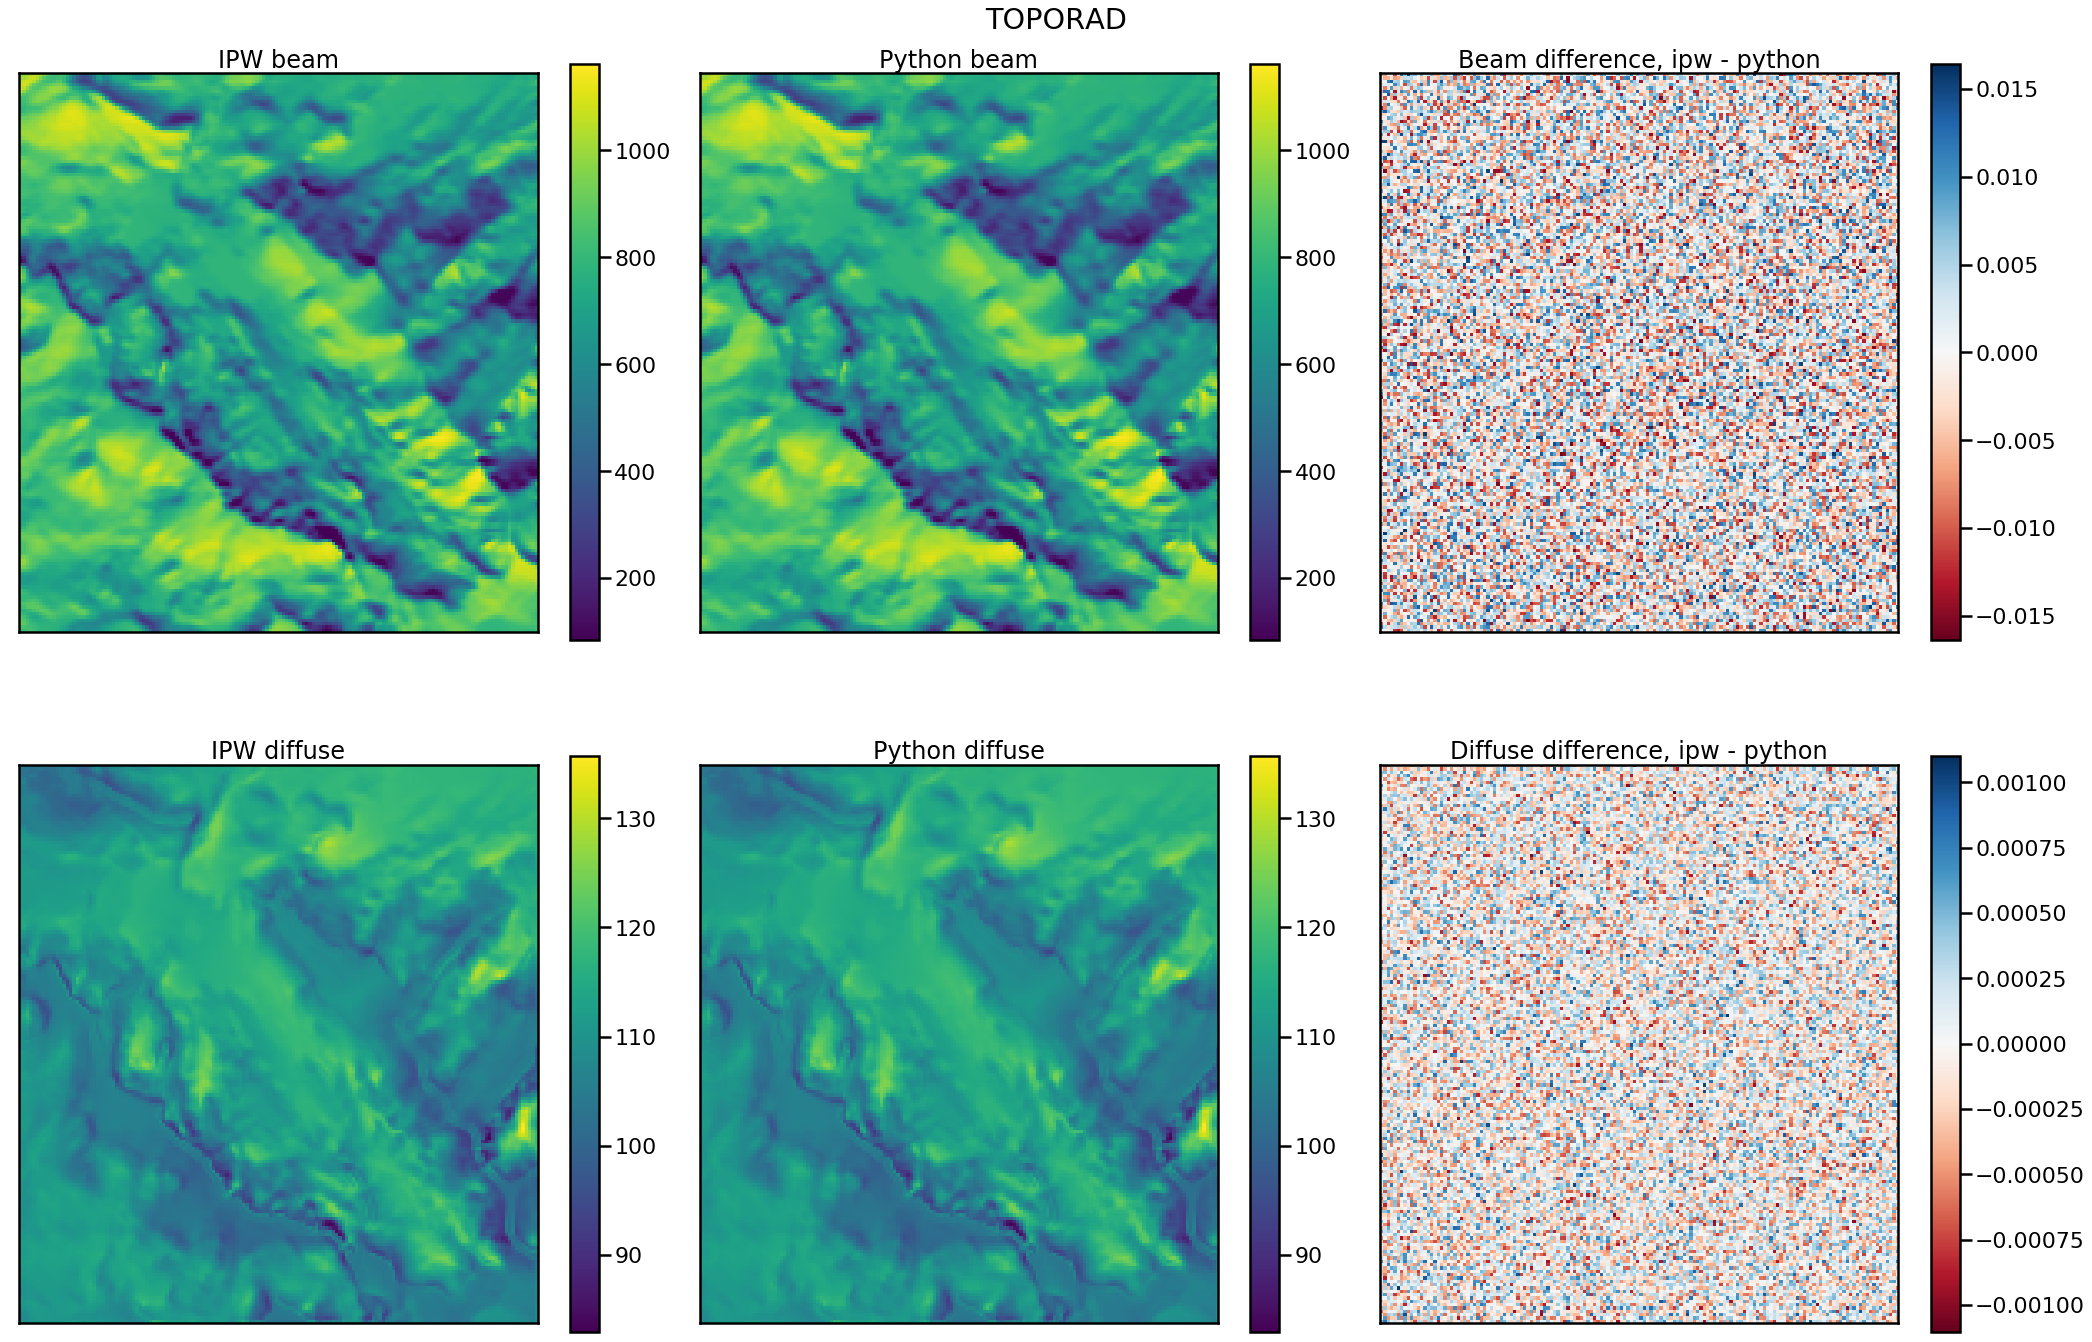

In [12]:
# toporad
# The only difference is bit resolution noise

# IPW toporad
# toporad requires a sun header that has the cosz and azimuth. Since this example hasn't done that, toporad sets cosz to 0.5

cmd = f"mux elevrad.ipw illum_angle.ipw svf.ipw tcf.ipw albedo.ipw | toporad -r {surface_albedo} -d > toporad.ipw"

print(cmd)
visp = sp.Popen(cmd, shell=True)
visp.wait()

toporad_ipw = ipw.IPW('toporad.ipw')

# Python toporad
erad = toporad.Elevrad(dem, solar_irradiance, cosz)

trad_beam, trad_diffuse = toporad.toporad(
    erad.beam,
    erad.diffuse,
    illum_ang,
    topo.sky_view_factor,
    topo.terrain_config_factor,
    0.5,
    surface_albedo=0.5)

# Plot
fig, ax = plt.subplots(2, 3, figsize = (30, 20))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
fig.suptitle('TOPORAD')

# IPW originals
im0 = ax[0, 0].imshow(toporad_ipw.bands[0].data)
ax[0, 0].set_title('IPW beam')
fig.colorbar(im0, ax=ax[0, 0])

im0 = ax[1, 0].imshow(toporad_ipw.bands[1].data)
ax[1, 0].set_title('IPW diffuse')
fig.colorbar(im0, ax=ax[1, 0])

# Python elevrad
im0 = ax[0, 1].imshow(trad_beam)
ax[0, 1].set_title('Python beam')
fig.colorbar(im0, ax=ax[0, 1])

im0 = ax[1, 1].imshow(trad_diffuse)
ax[1, 1].set_title('Python diffuse')
fig.colorbar(im0, ax=ax[1, 1])

# difference
d = toporad_ipw.bands[0].data - trad_beam
var_lim = max([abs(d.min()), abs(d.max())])
im2 = ax[0, 2].imshow(d, cmap='RdBu', vmin=-var_lim, vmax=var_lim)
ax[0, 2].set_title('Beam difference, ipw - python')
fig.colorbar(im2, ax=ax[0, 2])

d = toporad_ipw.bands[1].data - trad_diffuse
var_lim = max([abs(d.min()), abs(d.max())])
im2 = ax[1, 2].imshow(d, cmap='RdBu', vmin=-var_lim, vmax=var_lim)
ax[1, 2].set_title('Diffuse difference, ipw - python')
fig.colorbar(im2, ax=ax[1, 2])

# remove the x and y ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

stoporad -z 100 -t 0.2 -w 0.85 -g 0.3 -x 0.7,2.8 -s 127.85416666666666 -d 137.85416666666666 -f 0 -y 1990 -A 0.638023,-6.2971 -a 100.0 -m 2000.0 -c 2.0 -D stoporad_in.ipw > stoporad_vis.ipw


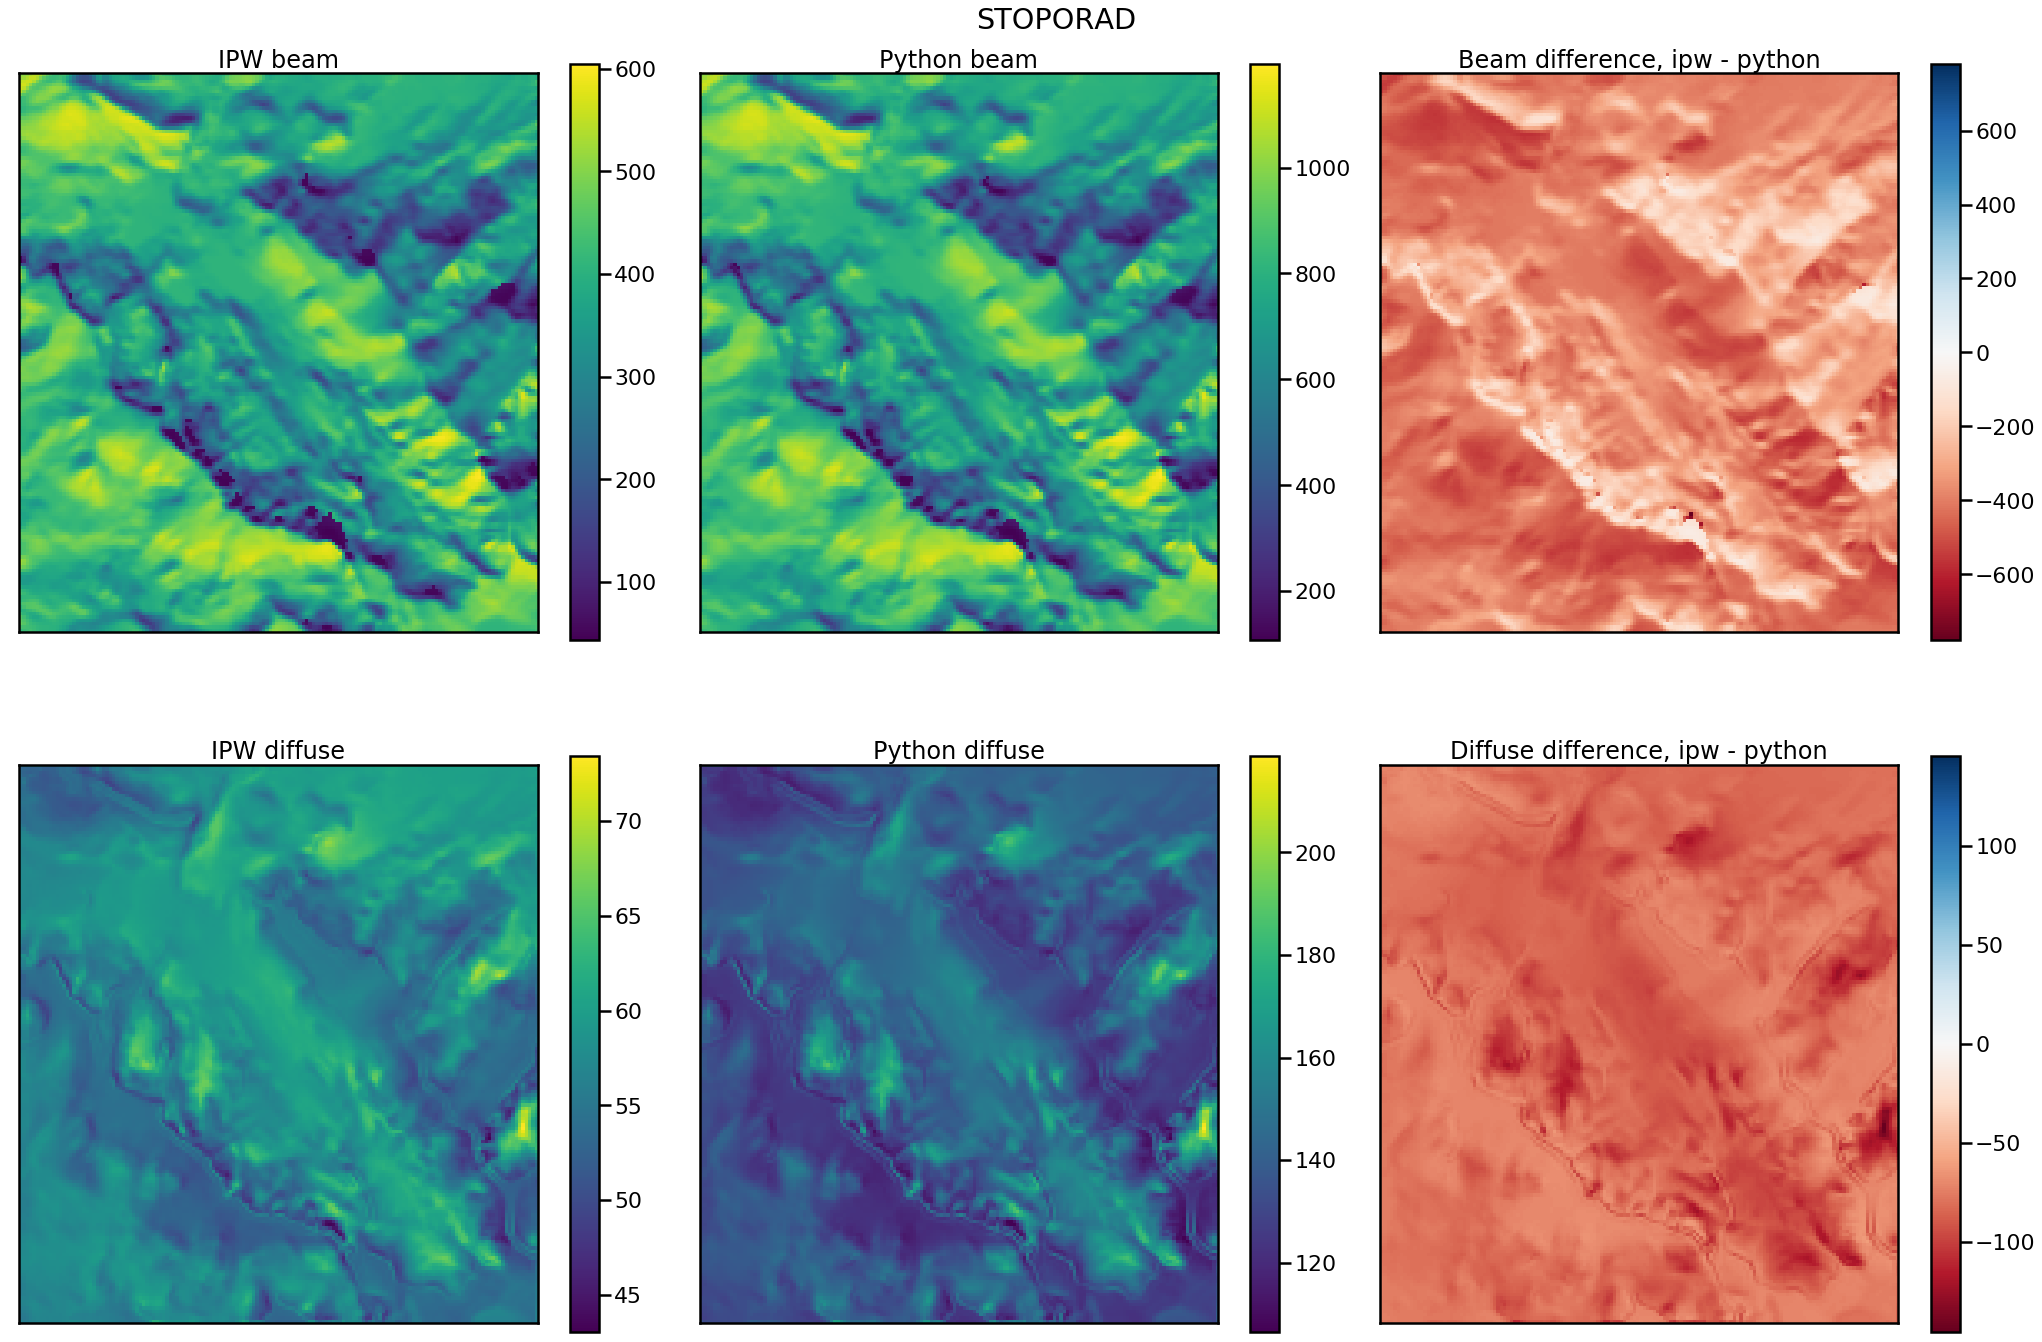

In [26]:
# stoporad for visible
min_storm_day = 10.0
wy_day, wyear = utils.water_day(date_time)
tz_min_west = int(np.abs(date_time.utcoffset().total_seconds()/60))

# IPW stoporad
cmd_vis = f"stoporad -z {tau_elevation} -t {tau} -w {omega} -g {scattering_factor} -x 0.7,2.8 -s {wy_day - min_storm_day} " \
        f"-d {wy_day} -f {tz_min_west} -y {wyear} -A {cosz},{azimuth} -a {grain_size} -m {max_grain} -c {dirt} -D stoporad_in.ipw > stoporad_vis.ipw"

print(cmd_vis)
visp = sp.Popen(cmd_vis, shell=True)
visp.wait()

stoporad_ipw = ipw.IPW('stoporad_vis.ipw')

# Python stoporad
srad_beam, srad_diffuse = toporad.stoporad_ipw(
    tau_elevation,
    tau,
    omega,
    scattering_factor,
    wavelength_range=[0.28, 0.7],
    start=min_storm_day,
    current_day=wy_day,
    time_zone=tz_min_west,
    year=wyear,
    latitude=topo.basin_lat,
    longitude=topo.basin_long,
    cosz=cosz,
    azimuth=azimuth,
    grain_size=100,
    max_grain=700,
    dirt=2,
    solar_irradiance=solar_irradiance,
    topo=topo)

# Plot
fig, ax = plt.subplots(2, 3, figsize = (30, 20))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
fig.suptitle('STOPORAD')

# IPW originals
im0 = ax[0, 0].imshow(stoporad_ipw.bands[0].data)
ax[0, 0].set_title('IPW beam')
fig.colorbar(im0, ax=ax[0, 0])

im0 = ax[1, 0].imshow(stoporad_ipw.bands[1].data)
ax[1, 0].set_title('IPW diffuse')
fig.colorbar(im0, ax=ax[1, 0])

# Python elevrad
im0 = ax[0, 1].imshow(srad_beam)
ax[0, 1].set_title('Python beam')
fig.colorbar(im0, ax=ax[0, 1])

im0 = ax[1, 1].imshow(srad_diffuse)
ax[1, 1].set_title('Python diffuse')
fig.colorbar(im0, ax=ax[1, 1])

# difference
d = stoporad_ipw.bands[0].data - srad_beam
var_lim = max([abs(d.min()), abs(d.max())])
im2 = ax[0, 2].imshow(d, cmap='RdBu', vmin=-var_lim, vmax=var_lim)
ax[0, 2].set_title('Beam difference, ipw - python')
fig.colorbar(im2, ax=ax[0, 2])

d = stoporad_ipw.bands[1].data - srad_diffuse
var_lim = max([abs(d.min()), abs(d.max())])
im2 = ax[1, 2].imshow(d, cmap='RdBu', vmin=-var_lim, vmax=var_lim)
ax[1, 2].set_title('Diffuse difference, ipw - python')
fig.colorbar(im2, ax=ax[1, 2])

# remove the x and y ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

In [ ]:
# look at intermediate stoporad steps -- horizon
cmd = f"horizon -u {cosz} -a {azimuth} dem.ipw > horizon.ipw"
visp = sp.Popen(cmd_vis, shell=True).wait()

horizon_ipw = ipw.IPW('horizon.ipw')

horizon_angles = horizon(azimuth, topo.dem, topo.dx)

thresh = np.tan(np.pi / 2 - np.arccos(cosz))
print(thresh)

mask = np.tan(np.abs(horizon_angles)) < thresh

fig, ax = plt.subplots(1, 2, figsize = (18, 10))
im = ax[0].imshow(horizon_ipw.bands[0].data)
fig.colorbar(im, ax=ax[0])

im2 = ax[1].imshow(1 * mask)
fig.colorbar(im2, ax=ax[1])

ialbedo -s 127.85416666666666 -d 137.85416666666666 -g 100.0 -m 2000.0 -c 2.0 -v illum_angle.ipw > albedo.ipw


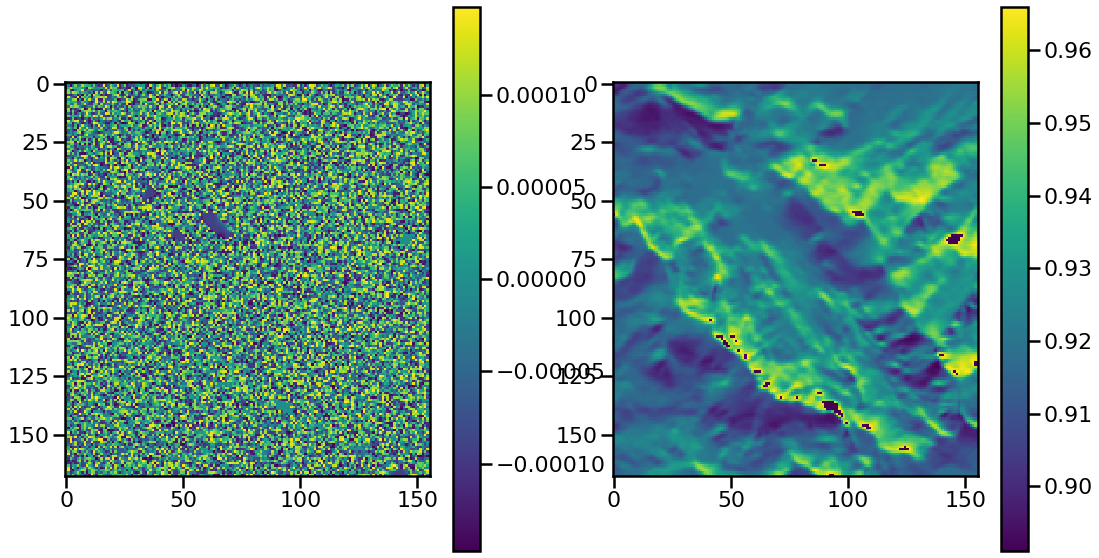

In [21]:
# look at intermediate stoporad steps -- albedo
from smrf.envphys.albedo import albedo
min_storm_day = 10
cmd = f"ialbedo -s {wy_day - min_storm_day} -d {wy_day} -g {grain_size} -m {max_grain} -c {dirt} -v illum_angle.ipw > albedo.ipw"
print(cmd)
visp = sp.Popen(cmd, shell=True).wait()

albedo_ipw = ipw.IPW('albedo.ipw')

alb_v, alb_ir = albedo(min_storm_day * np.ones_like(topo.dem), illum_ang, grain_size, max_grain, dirt)

fig, ax = plt.subplots(1, 2, figsize = (18, 10))
im = ax[0].imshow(albedo_ipw.bands[0].data-alb_v)
fig.colorbar(im, ax=ax[0])

im2 = ax[1].imshow(alb_v)
fig.colorbar(im2, ax=ax[1])

In [ ]:
azimuth = -90
cosz = 0.5
cmd = f"shade -u {cosz} -a {azimuth} gradient.ipw > shade.ipw"
print(cmd)
visp = sp.Popen(cmd, shell=True).wait()

shade_ipw = ipw.IPW('shade.ipw')

# plt.imshow(shade_ipw.bands[0].data-illum_ang)
plt.imshow()
plt.colorbar()

In [ ]:
# clean up IPW images
for fileName in glob.glob("*.ipw"):
  os.remove(fileName)